In [16]:
# 1. 환경 설정 및 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
import re

# [해결사] Pure Python 기반 형태소 분석기 Pecab
from pecab import PeCab

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows 기준)
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

In [17]:
# PeCab 초기화 (경로 문제에서 자유롭습니다)
pecab = PeCab()

# 테스트 실행
test_text = "배송이 너무 늦어서 짜증나요 제품은 괜찮은데"
print("형태소 분석 테스트:", pecab.nouns(test_text))

print("\n✓ 분석기 로드 및 한글 설정 완료!")

형태소 분석 테스트: ['배송', '짜증', '제품']

✓ 분석기 로드 및 한글 설정 완료!


In [18]:
# 2. 데이터 로드 및 통합
import os

# 파일 경로 설정 (notebooks 폴더 기준 상위 data 폴더)
one_star_path = '../data/review_ko/one_star_reviews_translated_begin2017.csv'
two_star_path = '../data/review_ko/two_star_reviews_claude_begin2017.csv'

# 1점 리뷰 로드
df1 = pd.read_csv(one_star_path)
df1['star'] = 1

# 2점 리뷰 로드
df2 = pd.read_csv(two_star_path)
df2['star'] = 2

# 데이터 통합
# 공통적으로 필요한 'order_id', 'message_ko', 'star' 컬럼 위주로 합칩니다.
df_reviews = pd.concat([
    df1[['order_id', 'message_ko', 'star']], 
    df2[['order_id', 'message_ko', 'star']]
], ignore_index=True)

# 결측치 제거 (번역 메시지가 없는 경우 제외)
df_reviews = df_reviews.dropna(subset=['message_ko'])

print(f"데이터 로드 완료!")
print(f"1점 리뷰: {len(df1):,}건")
print(f"2점 리뷰: {len(df2):,}건")
print(f"전체 분석 대상: {len(df_reviews):,}건")

df_reviews.head()

데이터 로드 완료!
1점 리뷰: 7,130건
2점 리뷰: 1,945건
전체 분석 대상: 9,074건


,order_id,message_ko,star
0,e6ce16cb79ec1d90b1da9085a6118aeb,매장에서 반품을 기다리는 중,1
1,acce194856392f074dbf9dada14d8d82,지금까지 유아용 침대용 매트리스 보호대 - 방수 면 제품을 받지 못했습니다. 이미 ...,1
2,1790eea0b567cf50911c057cf20f90f9,광고 설명에 나열된 모든 액세서리가 함께 제공되지 않을 뿐만 아니라 내가 구매한 제...,1
3,6ea2f835b4556291ffdc53fa0b3b95e8,당초 구매당시 12/21까지 상품 배송 예정이었습니다.오늘이 12/27인데 아직 도...,1
4,6ebaec694d7025e2ad4a05dba887c032,욕조가 깨져서 도착했어요.바로크 공연은 어떻게 하나요?,1


--- 평점별 리뷰 길이 통계 ---
       mean  median  max  count
star                           
1     52.96    47.0  213   7130
2     46.27    42.0  139   1944


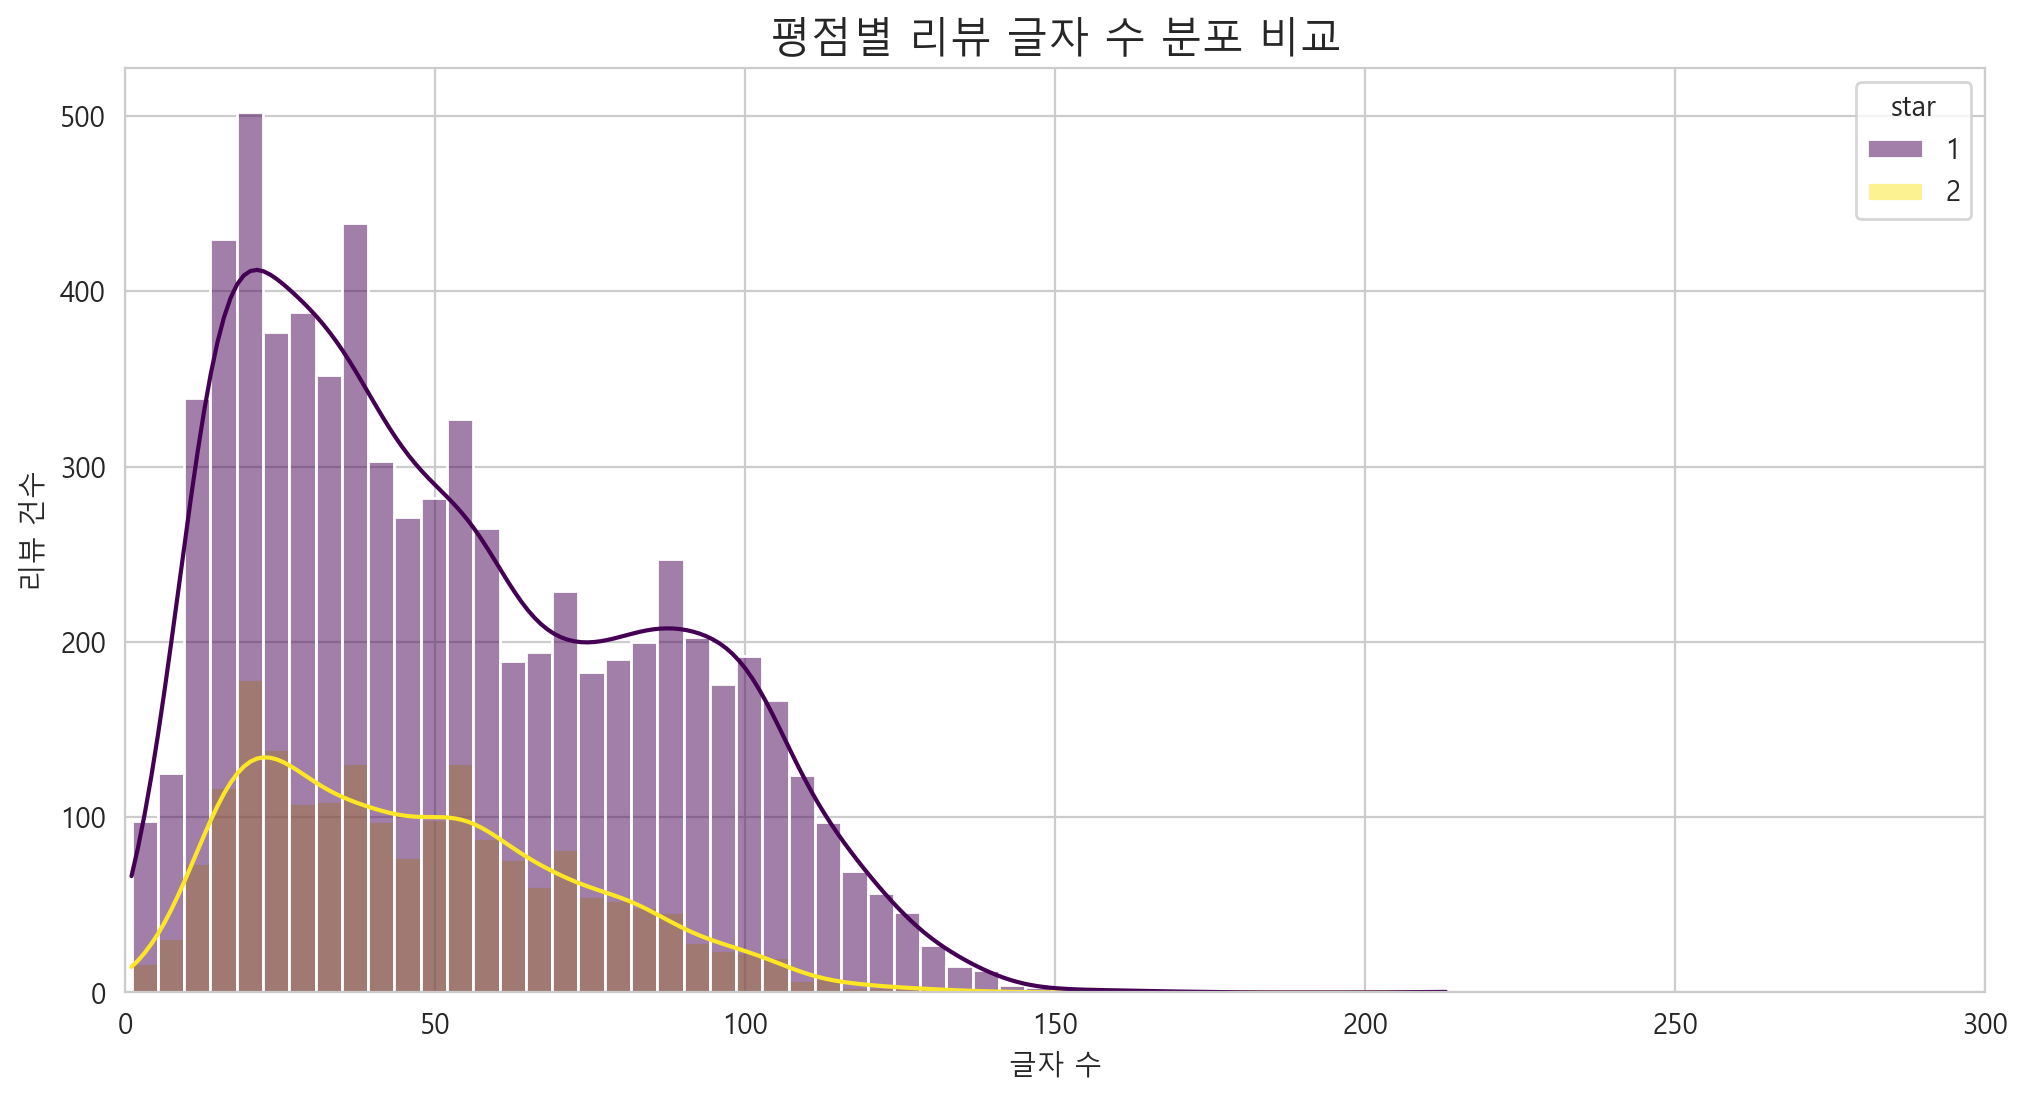


[분석 결과] 1점 리뷰의 평균 길이는 52.96자, 2점 리뷰는 46.27자로 확인됩니다.
1점 리뷰가 2점 리뷰에 비해 평균적으로 6.7자 정도 더 깁니다.


In [19]:
# 3. 기초 탐색적 분석 (EDA) - 리뷰 길이 분석

# 리뷰 글자 수 계산
df_reviews['text_len'] = df_reviews['message_ko'].astype(str).apply(len)

# 평점별 길이 통계
len_stats = df_reviews.groupby('star')['text_len'].agg(['mean', 'median', 'max', 'count']).round(2)
print("--- 평점별 리뷰 길이 통계 ---")
print(len_stats)

# 시각화: 리뷰 길이 분포 비교
plt.figure(figsize=(12, 6))
sns.histplot(data=df_reviews, x='text_len', hue='star', kde=True, palette='viridis', bins=50)
plt.title('평점별 리뷰 글자 수 분포 비교', fontsize=15)
plt.xlabel('글자 수')
plt.ylabel('리뷰 건수')
plt.xlim(0, 300) # 가독성을 위해 x축 범위를 제한 (대부분 300자 이내)
plt.show()

# 인사이트 출력
m1 = len_stats.loc[1, 'mean']
m2 = len_stats.loc[2, 'mean']
diff = "더 깁니다" if m1 > m2 else "더 짧거나 비슷합니다"
print(f"\n[분석 결과] 1점 리뷰의 평균 길이는 {m1}자, 2점 리뷰는 {m2}자로 확인됩니다.")
print(f"1점 리뷰가 2점 리뷰에 비해 평균적으로 {abs(m1-m2):.1f}자 정도 {diff}.")

In [20]:
# 4. 형태소 분석 및 키워드 빈도 추출

# 불용어 정의 (분석에 크게 의미 없는 단어들)
stopwords = ['하고', '하는', '에서', '입니다', '으로', '리뷰', '구매', '했는데', '습니다', '어요', '네요', '제품', '상품', '진짜', '너무', '완전', '매우']

def extract_keywords(text):
    # 명사(NNG, NNP)만 추출
    try:
        keywords = pecab.nouns(str(text))
        # 1글자 단어 제외 및 불용어 제거
        return [word for word in keywords if len(word) > 1 and word not in stopwords]
    except:
        return []

print("키워드 추출 중... (데이터 양에 따라 수십 초 정도 소요될 수 있습니다)")
# 각 리뷰에서 키워드 리스트 추출
df_reviews['keywords'] = df_reviews['message_ko'].apply(extract_keywords)

# 평점별 키워드 빈도 계산
def get_top_keywords(star_val, top_n=30):
    all_words = []
    for words in df_reviews[df_reviews['star'] == star_val]['keywords']:
        all_words.extend(words)
    return Counter(all_words).most_common(top_n)

top1 = get_top_keywords(1)
top2 = get_top_keywords(2)

# 결과 표시를 위한 데이터프레임 생성
df_top1 = pd.DataFrame(top1, columns=['Keyword', '1-Star Count'])
df_top2 = pd.DataFrame(top2, columns=['Keyword', '2-Star Count'])

print("\n--- 1점 리뷰 상위 키워드 ---")
print(df_top1.head(10))
print("\n--- 2점 리뷰 상위 키워드 ---")
print(df_top2.head(10))

키워드 추출 중... (데이터 양에 따라 수십 초 정도 소요될 수 있습니다)

--- 1점 리뷰 상위 키워드 ---
  Keyword  1-Star Count
0      배송          2327
1      도착          1353
2      주문           770
3      구입           471
4      요청           405
5      매장           397
6      지금           363
7      하나           354
8      연락           350
9      문제           344

--- 2점 리뷰 상위 키워드 ---
  Keyword  2-Star Count
0      배송           864
1      주문           491
2      도착           242
3      품질           125
4      기한           105
5      지연            93
6      포장            89
7      추천            88
8     우체국            83
9      교환            78


시각화 결과 저장 완료: ../images/low_review_eda/eda\keyword_comparison.png


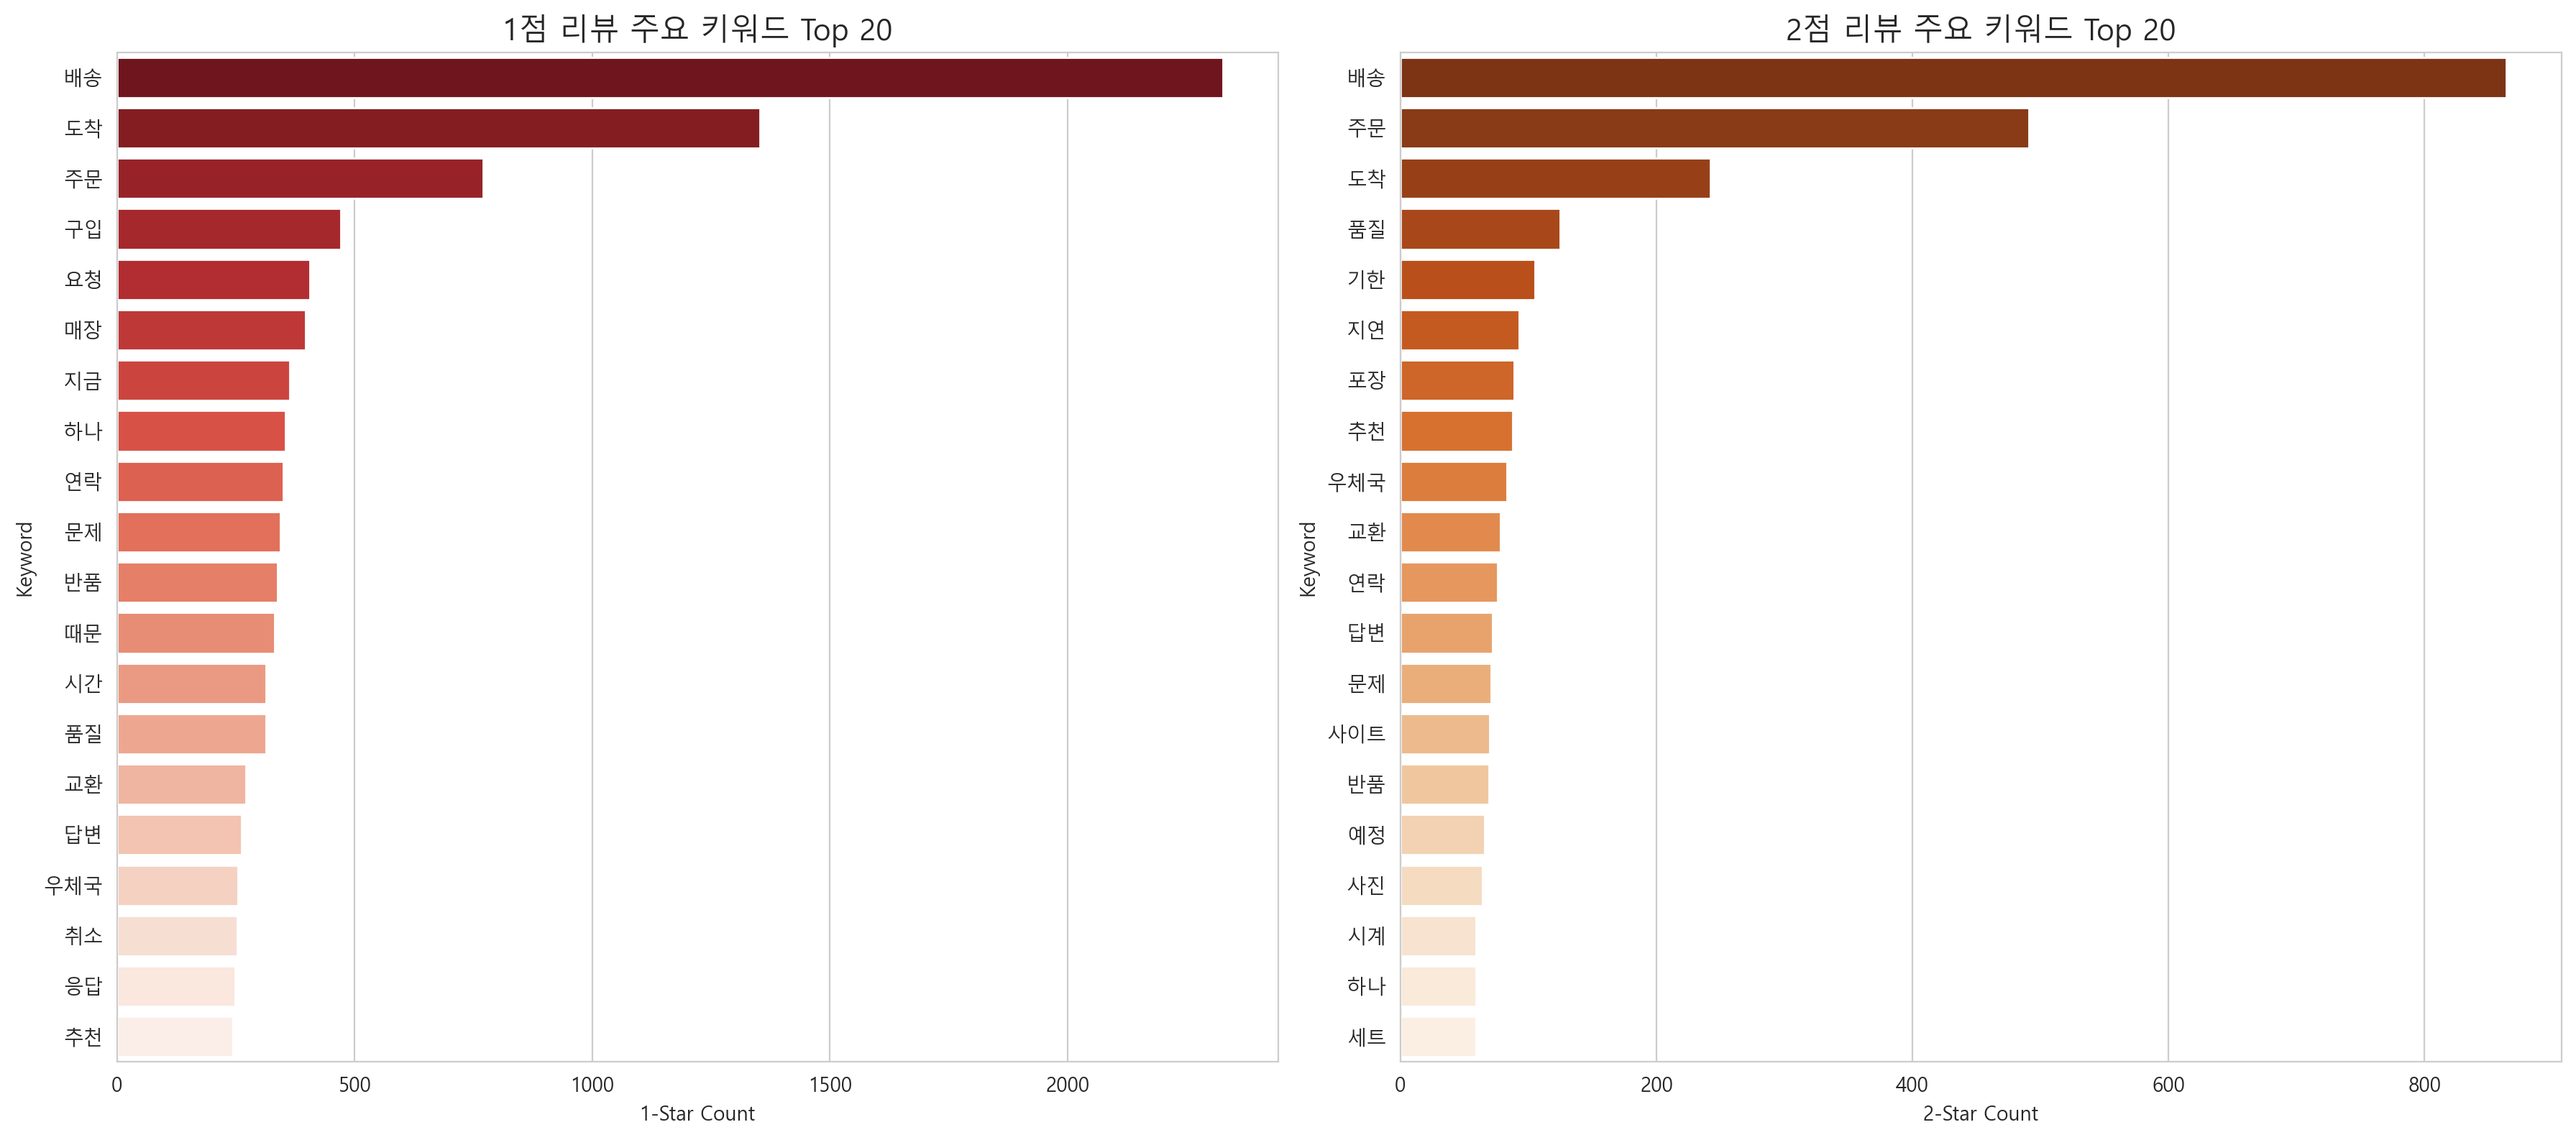


인사이트 리포트 저장 완료: ../images/low_review_eda/insight\grouping_validation.txt
------------------------------
[저평점 리뷰 그룹핑 검증 리포트]
1. 유사도 통계
   - 1점 키워드와 2점 키워드 간의 자카드 유사도: 0.36
   - 상위 30개 중 공통 키워드 개수: 16개

2. 주요 분석 내용
   - 공통 키워드: 광고, 교환, 답변, 도착, 매장, 문제, 반품, 배송, 사이트, 연락...
   - 1점 특화 키워드: 구입, 그것, 누락, 때문, 마감
   - 2점 특화 키워드: 결함, 기간, 기대, 기한, 마음

3. 그룹핑 권고
   - 유사도가 0.6 이상이거나 주요 불만 키워드가 겹칠 경우 '저점 리뷰(1-2점)'로 통합 분석하는 것이 통계적 유의성 확보에 유리함.



In [21]:
# 5. 키워드 시각화 저장 및 그룹핑 유사도 검증

import os

# 디렉토리 생성
eda_dir = '../images/low_review_eda/eda'
insight_dir = '../images/low_review_eda/insight'
os.makedirs(eda_dir, exist_ok=True)
os.makedirs(insight_dir, exist_ok=True)

# 시각화: 상위 키워드 비교 막대 그래프
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1점 리뷰 그래프
sns.barplot(data=df_top1.head(20), x='1-Star Count', y='Keyword', ax=axes[0], palette='Reds_r')
axes[0].set_title('1점 리뷰 주요 키워드 Top 20', fontsize=15)

# 2점 리뷰 그래프
sns.barplot(data=df_top2.head(20), x='2-Star Count', y='Keyword', ax=axes[1], palette='Oranges_r')
axes[1].set_title('2점 리뷰 주요 키워드 Top 20', fontsize=15)

plt.tight_layout()
viz_path = os.path.join(eda_dir, 'keyword_comparison.png')
plt.savefig(viz_path)
print(f"시각화 결과 저장 완료: {viz_path}")
plt.show()

# --- 그룹핑 타당성 검증 (Jaccard Similarity) ---
set1 = set(df_top1['Keyword'])
set2 = set(df_top2['Keyword'])

intersection = set1.intersection(set2)
union = set1.union(set2)
jaccard_sim = len(intersection) / len(union)

# 인사이트 정리
common_keywords = sorted(list(intersection))
only_in_1 = sorted(list(set1 - set2))
only_in_2 = sorted(list(set2 - set1))

insight_text = f"""[저평점 리뷰 그룹핑 검증 리포트]
1. 유사도 통계
   - 1점 키워드와 2점 키워드 간의 자카드 유사도: {jaccard_sim:.2f}
   - 상위 30개 중 공통 키워드 개수: {len(intersection)}개

2. 주요 분석 내용
   - 공통 키워드: {', '.join(common_keywords[:10])}...
   - 1점 특화 키워드: {', '.join(only_in_1[:5]) if only_in_1 else '없음'}
   - 2점 특화 키워드: {', '.join(only_in_2[:5]) if only_in_2 else '없음'}

3. 그룹핑 권고
   - 유사도가 0.6 이상이거나 주요 불만 키워드가 겹칠 경우 '저점 리뷰(1-2점)'로 통합 분석하는 것이 통계적 유의성 확보에 유리함.
"""

# 인사이트 파일 저장
insight_path = os.path.join(insight_dir, 'grouping_validation.txt')
with open(insight_path, 'w', encoding='utf-8') as f:
    f.write(insight_text)

print(f"\n인사이트 리포트 저장 완료: {insight_path}")
print("-" * 30)
print(insight_text)

워드클라우드 생성 중...


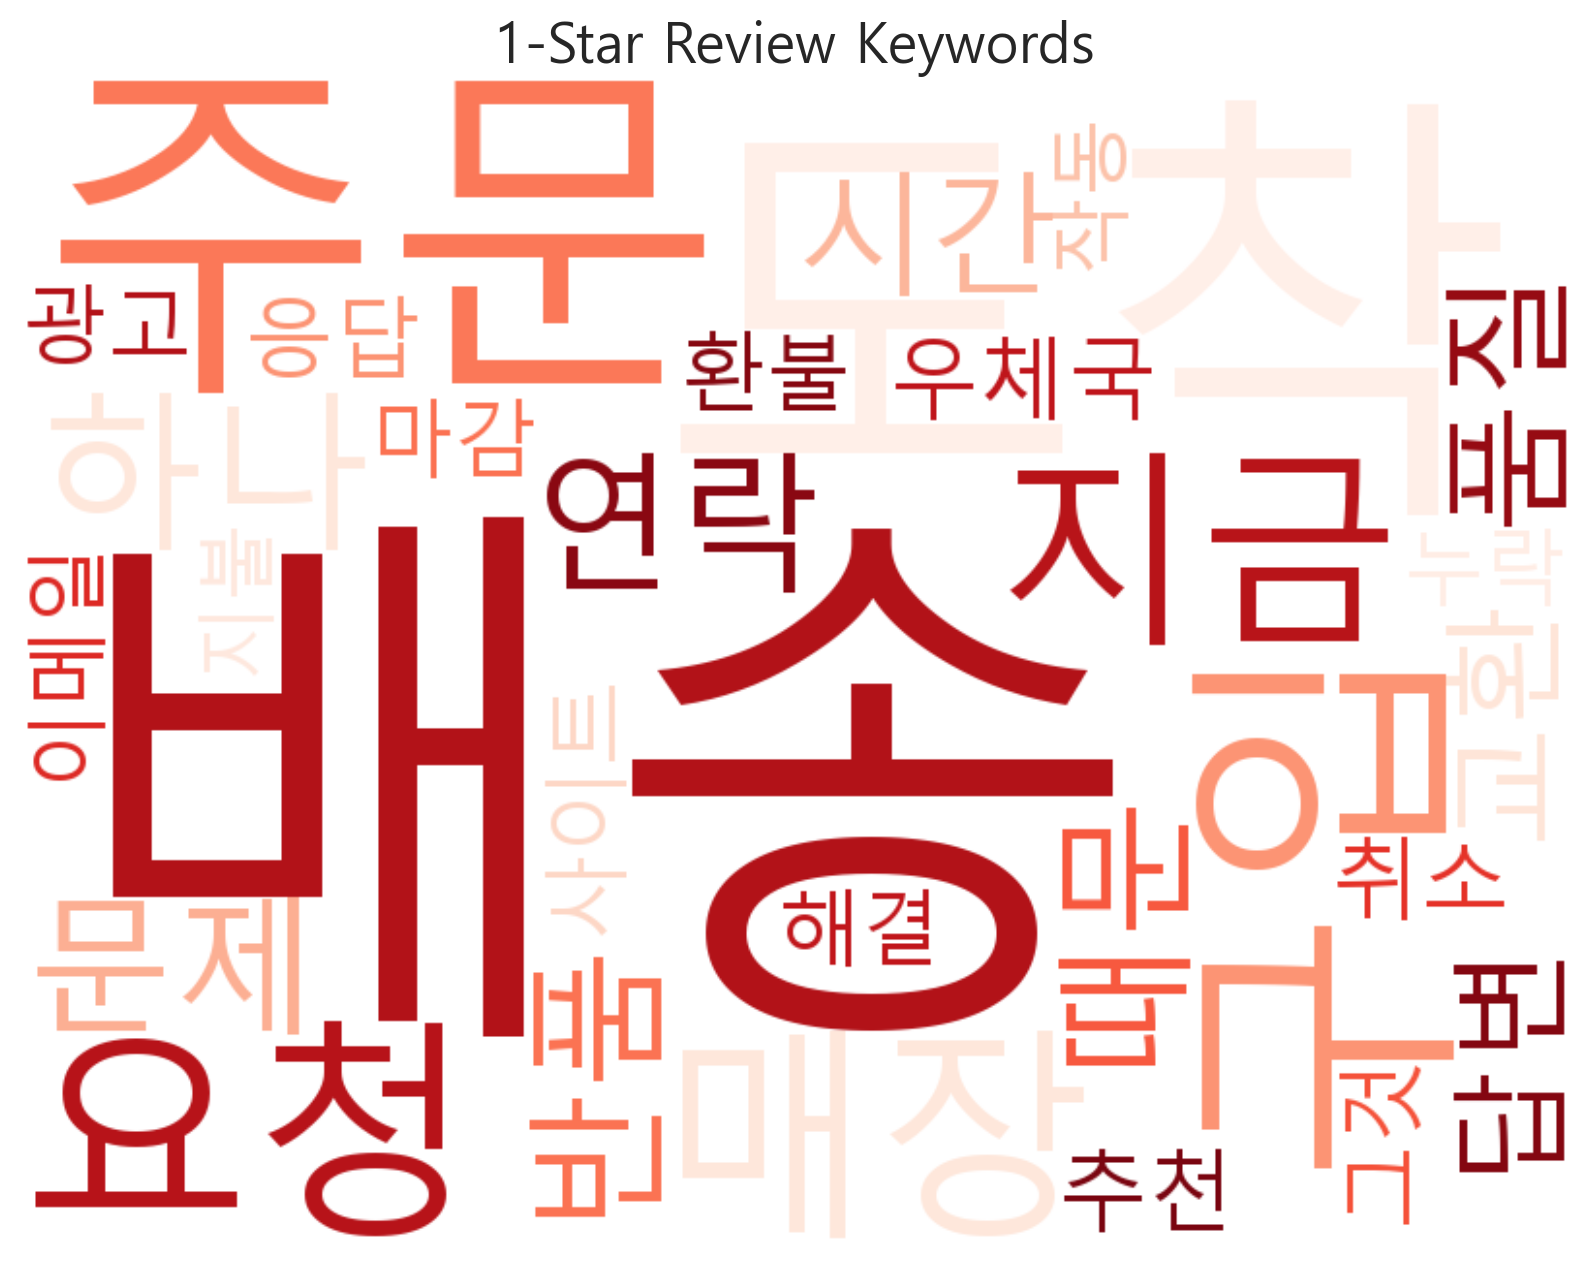

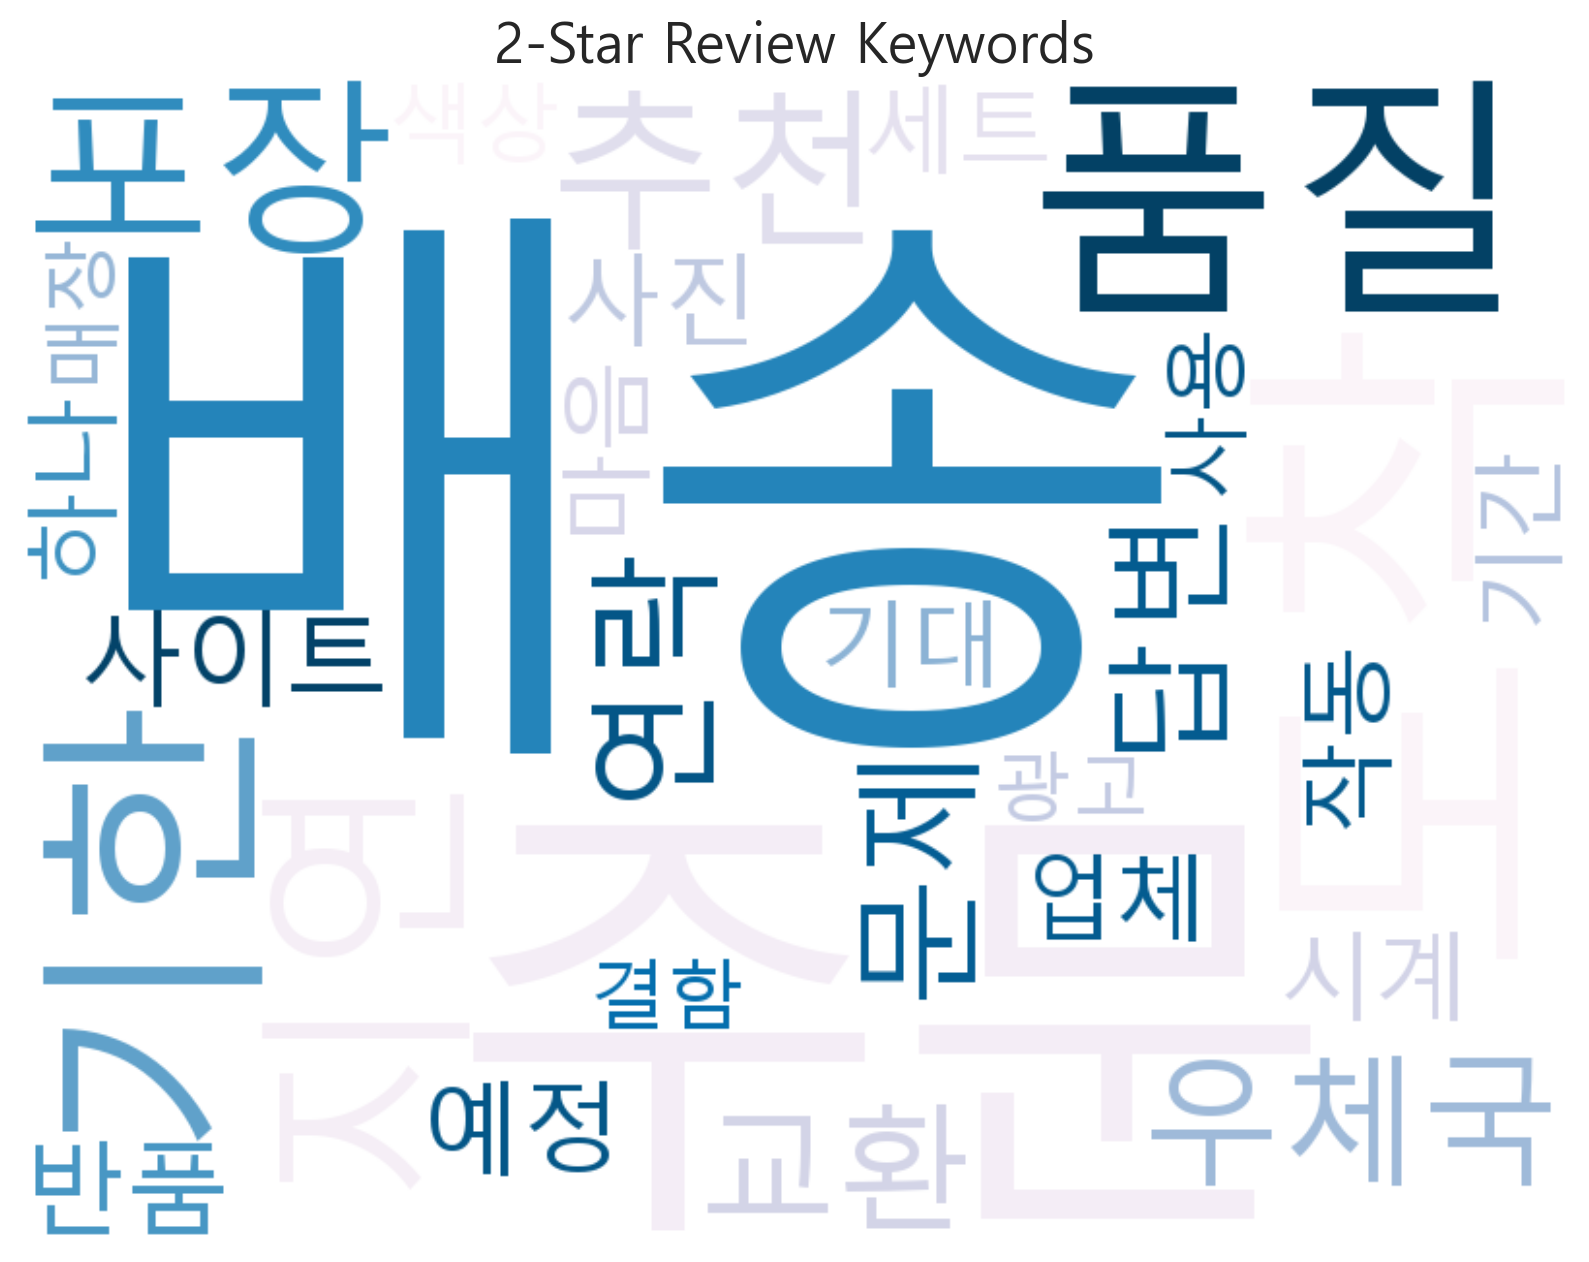

워드클라우드 저장 완료: ../images/low_review_eda/eda
인사이트 리포트 저장 완료: ../images/low_review_eda/insight


In [22]:
# 6. 평점별 워드클라우드 시각화 및 저장

from wordcloud import WordCloud

# 워드클라우드 생성 함수
def generate_wordcloud(data_dict, title, color_map, save_name):
    # 한글 폰트 설정 필수
    wc = WordCloud(
        font_path=font_path,
        background_color='white',
        width=800,
        height=600,
        colormap=color_map
    ).generate_from_frequencies(data_dict)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    
    # 저장
    save_full_path = os.path.join(eda_dir, save_name)
    plt.savefig(save_full_path)
    plt.show()
    return save_full_path

# 빈도 데이터를 딕셔너리로 변환
top1_dict = dict(top1)
top2_dict = dict(top2)

print("워드클라우드 생성 중...")
path1 = generate_wordcloud(top1_dict, '1-Star Review Keywords', 'Reds', 'wordcloud_1star.png')
path2 = generate_wordcloud(top2_dict, '2-Star Review Keywords', 'PuBu', 'wordcloud_2star.png')

# 인사이트 자동 저장
wc_insight = f"""[워드클라우드 분석 인사이트]
1. 1점 리뷰: '배송'과 '도착'의 크기가 압도적이며 '연락', '문제' 등 강한 부정어가 중심.
2. 2점 리뷰: 1점에 비해 '품질', '포장', '기한' 등의 키워드가 상대적으로 크게 나타남.
3. 결론: 1점은 '서비스 이행 자체의 실패'가 주원인이며, 2점은 '상품 자체나 상태에 대한 불만'이 섞여 있음.
"""
with open(os.path.join(insight_dir, 'wordcloud_insight.txt'), 'w', encoding='utf-8') as f:
    f.write(wc_insight)

print(f"워드클라우드 저장 완료: {eda_dir}")
print(f"인사이트 리포트 저장 완료: {insight_dir}")

In [23]:
# 7. 주요 불만 카테고리별 비중 산출 (근거 기반 분석)

# 분석 기반 카테고리 정의 (상위 빈도 단어 및 도메인 지식 기반)
category_keywords = {
    '물류/배송': ['배송', '도착', '지연', '늦게', '미수령', '우체국', '기한', '날짜', '예정'],
    '제품 품질': ['품질', '고장', '불량', '파손', '하자', '작동', '마감', '소재', '쓰레기'],
    '오배송/구성': ['다른', '잘못', '누락', '부족', '구성', '부품', '반대', '차이'],
    '서비스/응대': ['연락', '전화', '답변', '응대', '상담', '환불', '취소', '매장', '요청', '사이트']
}

def categorize_review(keywords):
    results = []
    for cat, words in category_keywords.items():
        # 각 카테고리 단어가 키워드 리스트에 포함되어 있는지 확인
        if any(word in keywords for word in words):
            results.append(cat)
    return results if results else ['기타/불명']

# 카테고리 태깅 실행
df_reviews['category'] = df_reviews['keywords'].apply(categorize_review)

# 평점별 카테고리 비중 계산 (중복 선택 가능하므로 전체 대비 비율 계산)
def get_category_stats(star_val):
    temp_df = df_reviews[df_reviews['star'] == star_val]
    cat_list = []
    for cats in temp_df['category']:
        cat_list.extend(cats)
    
    total_count = len(temp_df)
    counts = Counter(cat_list)
    
    # 비율 데이터프레임 생성
    stat_df = pd.DataFrame([
        {'Category': cat, 'Count': count, 'Ratio': (count / total_count)}
        for cat, count in counts.items()
    ]).sort_values(by='Ratio', ascending=False)
    
    return stat_df

stats_1 = get_category_stats(1)
stats_2 = get_category_stats(2)

# 결과 출력
print("--- 1점 리뷰 불만 카테고리 비중 (Total: 7,130건) ---")
print(stats_1[['Category', 'Ratio']].to_string(index=False))
print("\n--- 2점 리뷰 불만 카테고리 비중 (Total: 1,944건) ---")
print(stats_2[['Category', 'Ratio']].to_string(index=False))

# 결과 저장 (인사이트 8단계 대비 데이터 확보)
stats_1.to_csv(os.path.join(insight_dir, 'category_stats_1star.csv'), index=False)
stats_2.to_csv(os.path.join(insight_dir, 'category_stats_2star.csv'), index=False)

--- 1점 리뷰 불만 카테고리 비중 (Total: 7,130건) ---
Category    Ratio
   물류/배송 0.434923
   기타/불명 0.357363
  서비스/응대 0.226367
   제품 품질 0.116269
  오배송/구성 0.060449

--- 2점 리뷰 불만 카테고리 비중 (Total: 1,944건) ---
Category    Ratio
   물류/배송 0.439815
   기타/불명 0.383230
  서비스/응대 0.150720
   제품 품질 0.106996
  오배송/구성 0.046296


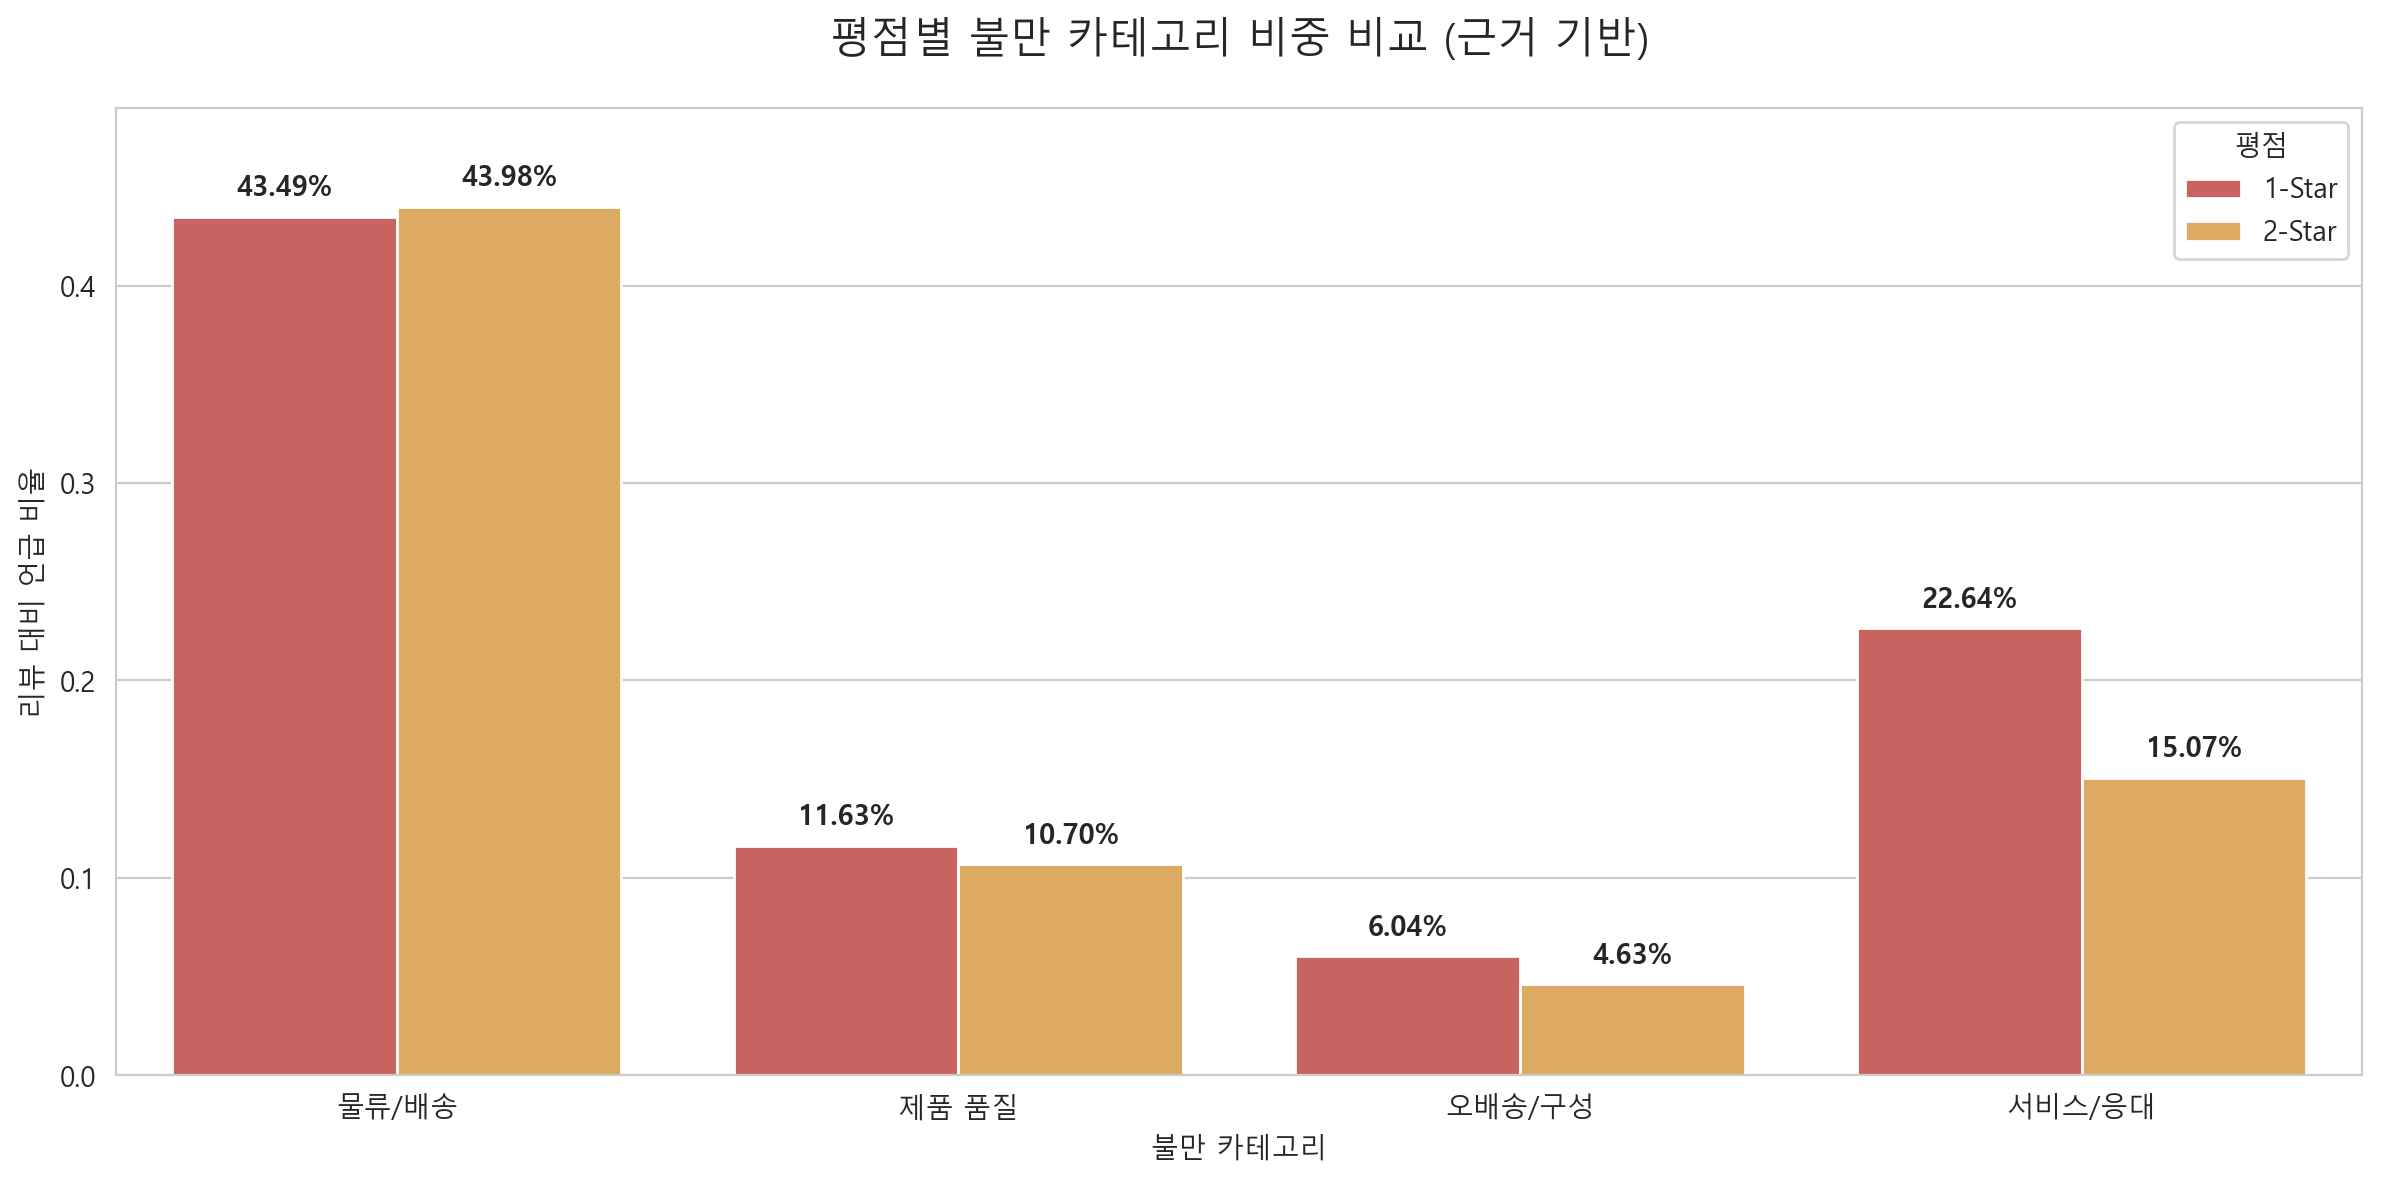

시각화 수정 및 저장 완료: ../images/low_review_eda/eda\category_ratio_comparison.png


In [25]:
# 8. [수정] 카테고리별 비중 시각화 및 최종 리포트 저장

# 시각화를 위한 데이터 재구조화
plot_data = []
for cat in category_keywords.keys():
    # 데이터가 존재할 때만 추가 (값이 없는 경우 0으로 처리)
    val1 = stats_1[stats_1['Category']==cat]['Ratio'].values[0] if not stats_1[stats_1['Category']==cat].empty else 0
    val2 = stats_2[stats_2['Category']==cat]['Ratio'].values[0] if not stats_2[stats_2['Category']==cat].empty else 0
    
    plot_data.append({'Category': cat, 'Star': '1-Star', 'Ratio': val1})
    plot_data.append({'Category': cat, 'Star': '2-Star', 'Ratio': val2})
df_plot = pd.DataFrame(plot_data)

# 시각화: 카테고리별 비중 비교 막대 그래프
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_plot, x='Category', y='Ratio', hue='Star', palette=['#d9534f', '#f0ad4e'])
plt.title('평점별 불만 카테고리 비중 비교 (근거 기반)', fontsize=15, pad=20)
plt.ylabel('리뷰 대비 언급 비율')
plt.xlabel('불만 카테고리')
plt.legend(title='평점')
plt.ylim(0, df_plot['Ratio'].max() + 0.05) # 수치 표시 공간 확보

# [수정된 수치 표시 로직] 0.00% 태그 방지
for p in ax.patches:
    height = p.get_height()
    # 높이가 0보다 큰 유효한 바에만 레이블을 붙입니다.
    if height > 0.001: 
        ax.annotate(f'{height:.2%}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), 
                    textcoords = 'offset points',
                    fontsize=10, 
                    fontweight='bold')

plt.tight_layout()
cat_viz_path = os.path.join(eda_dir, 'category_ratio_comparison.png')
plt.savefig(cat_viz_path)
plt.show()

print(f"시각화 수정 및 저장 완료: {cat_viz_path}")